In [21]:
#https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

In [22]:
datadir=r'C:\Users\saptarshi\Documents\__ml__\Car\CARDATA\Training DATA'

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [ ]:
columns=['center', 'left','right', 'steering', 'throttle','reverse', 'speed']
data=pd.read_csv(os.path.join (datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

In [25]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


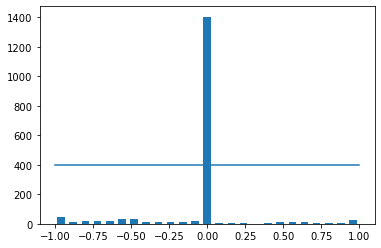

In [26]:
num_bins = 25
samples_per_bin=400
hist,bins=np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

total_data: 1743
removed: 1003
remaining: 740


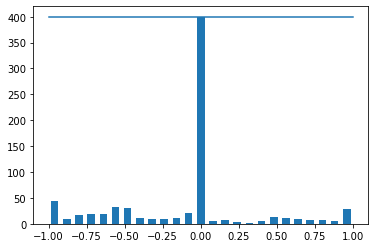

In [27]:
print('total_data:', len(data))
remove_list= []
for j in range(num_bins):
  list_= []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_= list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist,_ =np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [28]:
def load_img_steering(datadir, df):
  image_path= []
  steering= []
  for i in range(len(data)):
    indexed_data= data.iloc[i]
    center, left, right= indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings  = load_img_steering(datadir + '/IMG', data)

 

In [29]:
X_train, X_valid, y_train, y_valid= train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples:{}\nValid Samples:{}'.format(len(X_train), len(X_valid)))

Training Samples:592
Valid Samples:148


Text(0.5, 1.0, 'Validation set')

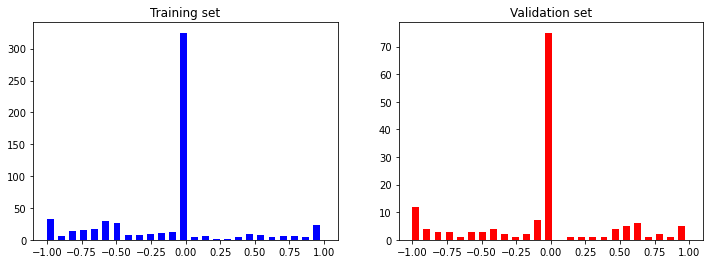

In [30]:
fig, axes= plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red' )
axes[1].set_title('Validation set')

In [31]:
def img_preprocess(img):
  img= mpimg.imread(img)
  img= img[60:135, :, :]
  img= cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (100, 100))
  img=img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

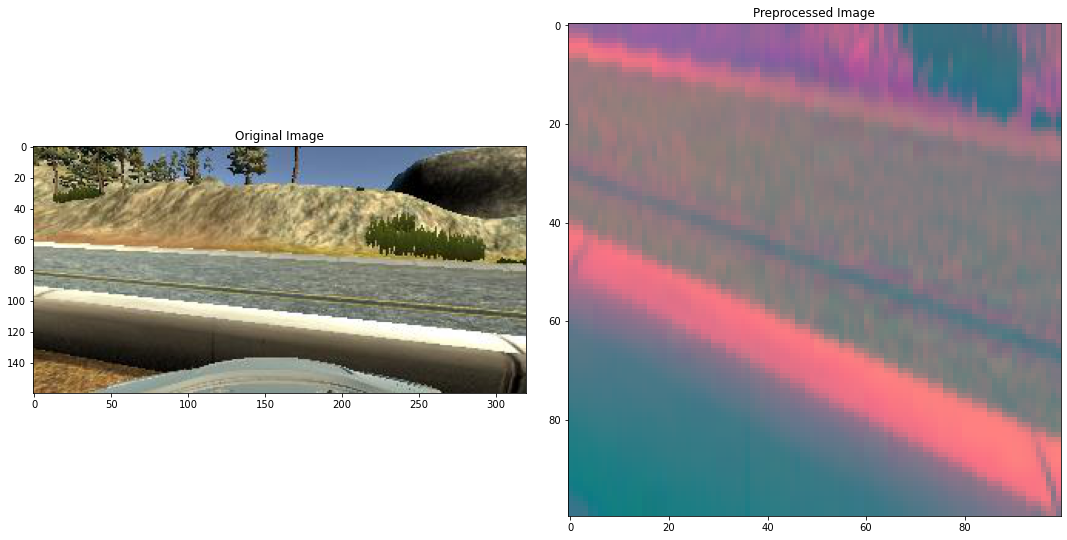

In [32]:
image = image_paths[100]
original_image= mpimg.imread(image)
preprocessed_image= img_preprocess(image)

fig, axs =plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [33]:
X_train=np.array(list(map(img_preprocess, X_train)))
X_valid=np.array(list(map(img_preprocess, X_valid)))

(592, 100, 100, 3)


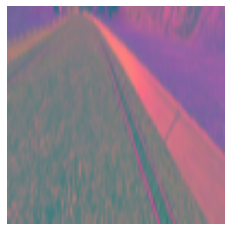

In [34]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis("off")
print(X_train.shape)

In [35]:
from tensorflow.keras.applications import ResNet50
#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [36]:
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False
    
for layer in resnet.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002222A48D070> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000022228FD2280> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022228FCBDF0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000022228FD8EB0> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000022228FD88B0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000022228FF2400> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000022228FF29D0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022228FF8220> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000022228FF22E0> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000022229000520> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002222

In [37]:
def nvidia_model():
    model = tf.keras.Sequential()
    model.add(resnet)

    model.add(Dropout(0.5))
  
    model.add(Flatten())
  
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

In [38]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 4, 4, 2048)        0         
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 32768)             0         
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 100)               3276900   
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 100)               0         
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 50)                5050      
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 50)               

C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [39]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), batch_size=128, verbose=1, shuffle=1)

Epoch 1/100
5/5 [==============================] - 5s 281ms/step - loss: 16.7659 - accuracy: 0.3328 - val_loss: 0.4333 - val_accuracy: 0.5068
Epoch 2/100
5/5 [==============================] - 0s 92ms/step - loss: 7.5485 - accuracy: 0.3885 - val_loss: 2.3442 - val_accuracy: 0.5068
Epoch 3/100
5/5 [==============================] - 0s 92ms/step - loss: 3.9040 - accuracy: 0.4088 - val_loss: 1.3562 - val_accuracy: 0.5068
Epoch 4/100
5/5 [==============================] - 0s 92ms/step - loss: 2.8637 - accuracy: 0.4392 - val_loss: 0.7077 - val_accuracy: 0.5068
Epoch 5/100
5/5 [==============================] - 0s 92ms/step - loss: 2.7274 - accuracy: 0.4291 - val_loss: 0.7866 - val_accuracy: 0.5068
Epoch 6/100
5/5 [==============================] - 0s 93ms/step - loss: 2.7766 - accuracy: 0.4223 - val_loss: 0.7527 - val_accuracy: 0.5068
Epoch 7/100
5/5 [==============================] - 0s 102ms/step - loss: 2.2941 - accuracy: 0.4071 - val_loss: 1.6352 - val_accuracy: 0.5068
Epoch 8/100
5/5 [

Epoch 59/100
5/5 [==============================] - 1s 119ms/step - loss: 0.6724 - accuracy: 0.4426 - val_loss: 0.2981 - val_accuracy: 0.5068
Epoch 60/100
5/5 [==============================] - 1s 118ms/step - loss: 0.8753 - accuracy: 0.4459 - val_loss: 0.2996 - val_accuracy: 0.5068
Epoch 61/100
5/5 [==============================] - 1s 116ms/step - loss: 0.7424 - accuracy: 0.4426 - val_loss: 0.3046 - val_accuracy: 0.5068
Epoch 62/100
5/5 [==============================] - 1s 113ms/step - loss: 0.7171 - accuracy: 0.4307 - val_loss: 0.3089 - val_accuracy: 0.5068
Epoch 63/100
5/5 [==============================] - 1s 115ms/step - loss: 0.7247 - accuracy: 0.4459 - val_loss: 0.3094 - val_accuracy: 0.5068
Epoch 64/100
5/5 [==============================] - 1s 113ms/step - loss: 0.6743 - accuracy: 0.4595 - val_loss: 0.3048 - val_accuracy: 0.5068
Epoch 65/100
5/5 [==============================] - 1s 116ms/step - loss: 0.7298 - accuracy: 0.4561 - val_loss: 0.2902 - val_accuracy: 0.5068
Epoch 

Text(0.5, 0, 'Epoch')

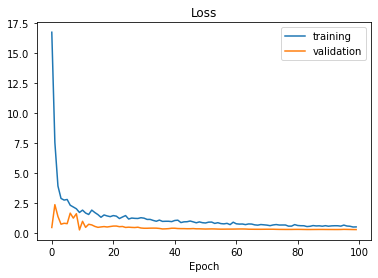

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')